In [1]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.5 MB/s eta 0:00:00


In [2]:
# Import necessary library
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
from einops import rearrange,repeat
from einops.layers.torch import Rearrange
import math
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 8]

In [3]:
TRAIN_RATE = 0.7
DATA_PATH = '/content/drive/MyDrive/Third Year/Sem 2/Business Data Analyst/dataset/Platinum.csv'
STATE_PATH = '/content/drive/MyDrive/Third Year/Sem 2/Business Data Analyst/Model State/Autoformer_Platinum_73.pth'
data = pd.read_csv(DATA_PATH)
data = data['Close'].values
train = data[:int(len(data) * TRAIN_RATE)]
test = data[int(len(data) * TRAIN_RATE):]

In [4]:
# Reimplement Autoformer's classes to build model

# Normalize layers based on number of features
class LayerNorm(nn.Module):
    def __init__(self,nfeat):
        super().__init__()
        self.norm = nn.LayerNorm(nfeat)

    def forward(self,X):
        X_norm = self.norm(X)
        return X_norm - X_norm.mean(dim = 1).unsqueeze(dim = 1)

# Moving average
class MovingAvg(nn.Module):
    def __init__(self, kernel_size, stride):
        super().__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # Padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

# Decomposite the time series
class SeriesDecomp(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.moving_avg = MovingAvg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

# Auto attention instead of Full attention in Transformer
class AutoAttentionLayer(nn.Module):
    def __init__(self,nfeat,nhid,nhead, kernel_size = 25, dropout = 0.05):
        super().__init__()
        self.q = nn.Linear(nfeat,nhid*nhead)
        self.k = nn.Linear(nfeat,nhid*nhead)
        self.v = nn.Linear(nfeat,nhid*nhead)
        self.nhead = nhead
        self.out = nn.Linear(nhead*nhid,nfeat)

        self.decomp1 = SeriesDecomp(kernel_size)
        self.decomp2 = SeriesDecomp(kernel_size)
        self.dropout = nn.Dropout(dropout)

        self.ffn = nn.Sequential(
            Rearrange('b l f -> b f l'),
            nn.Conv1d(nfeat,2*nfeat,kernel_size = 3, padding=1, bias = False),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Conv1d(2*nfeat,nfeat,kernel_size = 3, padding=1, bias = False),
            nn.Dropout(dropout),
            Rearrange('b f l -> b l f')
        )

    def forward(self,X,Y=None,Z=None,return_trend = False):
        self.topk = int(math.log(X.shape[1])+1)

        if Y is None and Z is None:
            qkv = (self.q(X),self.k(X),self.k(X))
        else:
            qkv = (self.q(X),self.k(Y),self.v(Z))

        q,k,v = map(lambda x: rearrange(x,'b t (h f)-> b h f t',h = self.nhead),qkv)

        Tq,Tk = q.shape[-1],k.shape[-1]
        if Tq > Tk:
            v = F.pad(v,(0,Tq-Tk),"constant",0)
            k = F.pad(k,(0,Tq-Tk),"constant",0)
        else:
            v = v[:,:Tq]
            k = k[:,:Tq]

        # Get time series autocorrelation
        q_fft = torch.fft.rfft(q,dim=-1)
        k_fft = torch.conj(torch.fft.rfft(k,dim=-1))
        lag = torch.fft.irfft(q_fft*k_fft)
        # Use lag
        corr = lag.mean(dim=(1,2))
        weights,delays = torch.topk(corr,self.topk,dim=-1)
        delays = torch.topk(weights.mean(dim=0),self.topk,dim=-1)[1]
        weights = torch.stack([weights[:,idx] for idx in delays],dim = -1)
        weights  = F.softmax(weights,dim=-1)
        # Fusion
        values = v.clone()
        for idx in range(self.topk):
            values[:,:,:,idx] = torch.roll(v[:,:,:,idx],-int(delays[idx]),-1) * rearrange(weights[:,idx],"b ->b 1 1 ")

        values = self.out(rearrange(values,'b h f t -> b t (h f)'))

        X = X + self.dropout(values)

        # Get residual (seasonality)
        y, trend1 = self.decomp1(X)
        y = self.ffn(y) #ffn
        res,trend2 = self.decomp2(X+y)

        if not return_trend:
            return res
        else:
            return res,trend1+trend2

# Encoder to encode time series input
class Encoder(nn.Module):
    def __init__(self,nlayers = 2,nfeat = 2048,nhid = 256,nhead = 8, kernel_size = 25,dropout = 0.05):
        super().__init__()
        self.modulelist = nn.ModuleList([AutoAttentionLayer(nfeat,nhid,nhead,kernel_size,dropout) for i in range(nlayers)])
        self.norm = LayerNorm(nfeat)

    def forward(self,X):
        for m in self.modulelist:
            X = m(X)
        X = self.norm(X)
        return X

# Decoder layer to decode and give prediction
class DecoderLayer(nn.Module):
    def __init__(self,nfeat, nembed = 2048,nhid = 256,nhead = 8, kernel_size = 25,dropout = 0.05):
        super().__init__()
        self.self_attn = AutoAttentionLayer(nembed,nhid,nhead,kernel_size,dropout)
        self.cross_attn = AutoAttentionLayer(nembed,nhid,nhead,kernel_size,dropout)
        self.dropout = nn.Dropout(dropout)
        self.decomp = SeriesDecomp(kernel_size)
        self.projection = nn.Sequential(
                Rearrange('b t f-> b f t'),
                nn.Conv1d(in_channels=nembed, out_channels=nfeat, kernel_size=3, padding=1,
                                        padding_mode='circular', bias=False),
                Rearrange('b f t -> b t f'),
            )

    def forward(self,X,Y):
        X = X + self.dropout(self.self_attn(X))
        season1,trend1 = self.decomp(X)

        seanson2, trend2 = self.cross_attn(season1,Y,Y,return_trend = True)
        season = season1 + self.dropout(seanson2)

        trend = self.projection(trend1+trend2)
        # return X,trend
        return season,trend

class Decoder(nn.Module):
    def __init__(self,nlayers = 1,nfeat = 8 , nembed = 2048,nhid = 256,nhead = 8, kernel_size = 25,dropout = 0.05):
        super().__init__()
        self.modulelist = nn.ModuleList([DecoderLayer(nfeat,nembed,nhid,nhead,kernel_size,dropout) for i in range(nlayers)])
        self.norm = LayerNorm(nfeat)
        self.projection = nn.Sequential(
                Rearrange('b t f-> b f t'),
                nn.Conv1d(in_channels=nembed, out_channels=nfeat, kernel_size=3, padding=1,
                                        padding_mode='circular', bias=False),
                Rearrange('b f t -> b t f'),
            )

    def forward(self,X,Y,trend):
        for m in self.modulelist:
            X,residual_trend = m(X,Y)
            trend += residual_trend

        X = self.norm(self.projection(X))
        return X,trend

# Use position embedding to avoid no time stamp input
class PosEmbedding(nn.Module):
    def __init__(self,nfeat,max_length = 20000):
        super().__init__()
        position = torch.arange(0, max_length).float().unsqueeze(1)
        div_term = (torch.arange(0, nfeat, 2).float() * -(math.log(10000.0) / nfeat)).exp()

        self.pe = torch.zeros(max_length, nfeat).float()
        self.pe[:, 0::2] = torch.sin(position * div_term)
        self.pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = self.pe.unsqueeze(0)
    def forward(self, x):
        return self.pe[:, :x.size(1),:].to(x.device)

# Temporal embedding can highly improve the performance
class TemporalEmbedding(nn.Module):
    def __init__(self, nfeat, max_size = 100, max_stamps = 20):
        super(TemporalEmbedding, self).__init__()
        self.max_stamps = max_stamps
        self.max_size = max_size

        self.embed_list = nn.ModuleList()
        for i in range(max_stamps):
            self.embed_list.append(nn.Embedding(max_size, nfeat))

    def forward(self, x):
        num_stamps = x.shape[-1]
        x = x.long()

        embeddings_list = []
        for i in range(num_stamps):
            embed = self.embed_list[i]
            embeddings_list.append(embed(x[:,:,i]))
        return sum(embeddings_list)

# Autoformer model class
class AutoFormer(nn.Module):
    def __init__(self,pred_length = None ,encoder_layers=2,decoder_layers=1,nfeat = 8,nembed = 2048,nhid = 256,nhead = 8, kernel_size = 25,dropout = 0.05):
        super().__init__()
        self.enc_embedding = nn.Sequential(
                Rearrange('b t f-> b f t'),
                nn.Conv1d(in_channels=nfeat, out_channels=nembed, kernel_size=3, padding=1,
                                        padding_mode='circular', bias=False),
                Rearrange('b f t -> b t f'),
            )
        self.dec_embedding = nn.Sequential(
                Rearrange('b t f-> b f t'),
                nn.Conv1d(in_channels=nfeat, out_channels=nembed, kernel_size=3, padding=1,
                                        padding_mode='circular', bias=False),
                Rearrange('b f t -> b t f'),
            )
        self.trend_projection = nn.Linear(nembed,nfeat)
        self.seasonal_projection = nn.Linear(nembed,nfeat)

        self.encoder = Encoder(encoder_layers,nembed,nhid,nhead,kernel_size,dropout)
        self.decoder = Decoder(decoder_layers,nfeat,nembed,nhid,nhead,kernel_size,dropout)

        self.decomp = SeriesDecomp(kernel_size)

        self.pos_embedding = PosEmbedding(nembed)
        self.time_embedding = TemporalEmbedding(nembed)
        self.pred_length = pred_length

    def forward(self,X_enc,X_stamps = None,y_stamps = None):
        T = X_enc.shape[1]
        # Decoder input preparation
        mean = torch.mean(X_enc, dim=1).unsqueeze(1).repeat(1, self.pred_length, 1)
        zeros = torch.zeros_like(mean,device = X_enc.device)

        # Decomposition
        seasonal_init,trend_init = self.decomp(X_enc)
        trend_init = torch.cat([trend_init[:, -self.pred_length:, :], mean], dim=1)
        seasonal_init = torch.cat([seasonal_init[:, -self.pred_length:, :], zeros], dim=1)

        # Encoder
        X_enc = self.enc_embedding(X_enc)
        if X_stamps is None:
            X_enc += self.pos_embedding(X_enc)
        else:
            X_enc += self.time_embedding(X_stamps)

        enc_out = self.encoder(X_enc)
        # Decoder
        X_dec = self.dec_embedding(seasonal_init)
        if y_stamps is None:
            X_dec += self.pos_embedding(X_dec)
        else:
            X_dec[:,-self.pred_length:,:] = X_dec[:,-self.pred_length:,:] + self.time_embedding(y_stamps)

        seasonal_part,trend_part = self.decoder(X_dec,enc_out,trend_init)
        X = seasonal_part + trend_part
        X = X[:,-self.pred_length:,:]

        return X

    def forecast(self, X_enc, X_stamps=None, y_stamps=None, pred_length=24):
        self.pred_length = pred_length
        T = X_enc.shape[1]
        # Decoder input preparation
        mean = torch.mean(X_enc, dim=1).unsqueeze(1).repeat(1, self.pred_length, 1)
        zeros = torch.zeros_like(mean,device = X_enc.device)

        # Decomposition
        seasonal_init,trend_init = self.decomp(X_enc)
        trend_init = torch.cat([trend_init[:, -self.pred_length:, :], mean], dim=1)
        seasonal_init = torch.cat([seasonal_init[:, -self.pred_length:, :], zeros], dim=1)

        # Encoder
        X_enc = self.enc_embedding(X_enc)
        if X_stamps is None:
            X_enc += self.pos_embedding(X_enc)
        else:
            X_enc += self.time_embedding(X_stamps)

        enc_out = self.encoder(X_enc)
        # Decoder
        X_dec = self.dec_embedding(seasonal_init)
        if y_stamps is None:
            X_dec += self.pos_embedding(X_dec)
        else:
            X_dec[:,-self.pred_length:,:] = X_dec[:,-self.pred_length:,:] + self.time_embedding(y_stamps)

        seasonal_part,trend_part = self.decoder(X_dec,enc_out,trend_init)
        X = seasonal_part + trend_part
        X = X[:,-self.pred_length:,:]

        return X

In [5]:
# Class to read and process dataset, split parameter is used to split to train and test set
class dataset(Dataset):
    def __init__(self,input_length = 96,preds_length = 96 ,path = DATA_PATH,
                 train = 'train',split = (TRAIN_RATE,1 - TRAIN_RATE)):
        super().__init__()
        df = pd.read_csv(path)
        # Time series feature
        df_stamp = pd.DataFrame()
        df['Date'] = pd.to_datetime(df['Date'])
        df_stamp['Month'] = df['Date'].apply(lambda row:row.month,1)
        df_stamp['Weekday'] = df['Date'].apply(lambda row:row.weekday(),1)
        df_stamp['Hour'] = df['Date'].apply(lambda row:row.hour,1)
        df_stamp['Day'] = df['Date'].apply(lambda row:row.day,1)
        df_stamp = df_stamp[['Month','Weekday','Hour','Day']].values

        # Scaled data
        cols = ['Open','Close','High','Low']
        df = df[cols]
        self.scale_fn = StandardScaler()
        train_length = int((len(df)-input_length-preds_length)*split[0])
        test_length = int((len(df)-input_length-preds_length)*split[1])
        train_data = df[:train_length].values
        self.scale_fn.fit(train_data)
        df = self.scale_fn.transform(df.values)

        if train == 'train':
            self.df = df[:train_length]
            self.df_stamp = df_stamp[:train_length]
        else:
            self.df = df[train_length+test_length:]
            self.df_stamp = df_stamp[train_length+test_length:]

        self.input_length = input_length
        self.preds_length = preds_length
        self.train = train

        self.df = torch.tensor(self.df,device = 'cuda' if torch.cuda.is_available() else 'cpu').float()
        self.df_stamp = torch.tensor(self.df_stamp,device = 'cuda' if torch.cuda.is_available() else 'cpu')


    def __inverse_transform__(self,X):
        return self.scale_fn.inverse_transform(X)

    def __len__(self):
        return len(self.df) - self.input_length - self.preds_length + 1

    def __getitem__(self,index):
        X = self.df[index:index+self.input_length]
        X_stamp = self.df_stamp[index:index+self.input_length]

        y = self.df[index+self.input_length:index+self.input_length+self.preds_length]
        y_stamp = self.df_stamp[index+self.input_length:index+self.input_length+self.preds_length]

        return X,X_stamp,y,y_stamp

# Class to create forecast dataset
class ForecastDataset(Dataset):
    def __init__(self, input_length, path=DATA_PATH):
        df = pd.read_csv(path)
        df_stamp = pd.DataFrame()
        df['Date'] = pd.to_datetime(df['Date'])
        df_stamp['Month'] = df['Date'].apply(lambda row: row.month, 1)
        df_stamp['Weekday'] = df['Date'].apply(lambda row: row.weekday(), 1)
        df_stamp['Hour'] = df['Date'].apply(lambda row: row.hour, 1)
        df_stamp['Day'] = df['Date'].apply(lambda row: row.day, 1)
        df_stamp = df_stamp[['Month', 'Weekday', 'Hour', 'Day']].values

        cols = ['Open', 'Close', 'High', 'Low']
        df = df[cols]
        self.scale_fn = StandardScaler()
        train_length = int(len(df) * TRAIN_RATE)
        train_data = df[:train_length].values
        self.scale_fn.fit(train_data)
        df = self.scale_fn.transform(df.values)

        self.df = torch.tensor(df[-input_length:], device='cuda' if torch.cuda.is_available() else 'cpu').float()
        self.df_stamp = torch.tensor(df_stamp[-input_length:], device='cuda' if torch.cuda.is_available() else 'cpu')

        self.input_length = input_length

    def __len__(self):
        return 1

    def __getitem__(self, index):
        X = self.df
        X_stamp = self.df_stamp
        return X, X_stamp

In [6]:
# Function used to train model
def train_per_epoch(dataloader):
    model.train()
    loss_report = 0.
    bar = tqdm(dataloader)
    for X,X_stamp,y,y_stamp in bar:
        optim.zero_grad()
        X = X.float()
        y = y.float()
        pred = model(X,X_stamp,y_stamp)
        loss = loss_fn(y,pred)
        loss.backward()
        optim.step()
        schedule.step()
        loss_report += loss.clone().detach().cpu().item()
        # bar.set_description("Train loss {:.4f} ".format(loss.clone().detach().cpu().item()))
    return loss_report/len(dataloader)

# Evaluate model after training
def valid_per_epoch(dataloader):
    model.eval()
    loss_report = 0.
    bar = tqdm(dataloader)
    preds = []
    labels = []
    for X,X_stamp,y,y_stamp in bar:
        with torch.no_grad():
            X = X.float()
            y = y.float()
            pred = model(X,X_stamp,y_stamp)
            loss = loss_fn(y,pred)
            loss_report += loss.clone().detach().cpu().item()
            # bar.set_description("Valid loss {:.4f}".format(loss.clone().detach().cpu().item()))

            preds.append(pred.clone().detach().cpu().numpy())
            labels.append(y.clone().detach().cpu().numpy())

    preds = np.concatenate(preds,axis = 0)
    labels = np.concatenate(labels,axis = 0)
    loss_report = {
        'loss': loss_report/len(dataloader),
        'mape': np.abs(((labels-preds)/labels)).mean(),
        'mse': ((labels-preds)**2).mean(),
        'rmse': math.sqrt(((labels-preds)**2).mean())
    }
    return loss_report

In [7]:
epoch = 15
batch_size = 32
lr = 1e-4
input_length = 20
pred_length = 40

train_dataset = dataset(input_length,pred_length,train = 'train')
test_dataset = dataset(input_length,pred_length,train = 'test')


train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,drop_last=False)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True,drop_last=False)

In [8]:
model = AutoFormer(pred_length,2,1,nfeat=4,nembed=8,nhid = 512,nhead = 8)
loss_fn = torch.nn.MSELoss()
optim = torch.optim.Adam(model.parameters(),lr=lr)
schedule = torch.optim.lr_scheduler.CosineAnnealingLR(optim,T_max=len(train_dataloader)*epoch,eta_min=1e-7)
MAPE = 0
MSE = 0
RMSE = 0
for e in range(epoch):
    print(f'Epoch {e+1}/{epoch}:')
    loss_train = train_per_epoch(train_dataloader)
    report = valid_per_epoch(test_dataloader)
    print('Train loss is {:.5f}'.format(loss_train))
    print('Test loss is {:.5f} '.format(report['loss']))
    print('-----------------------------------------------------')
    MAPE += report['mape']
    MSE += report['mse']
    RMSE += report['rmse']
MAPE = MAPE / epoch
MSE = MSE / epoch
RMSE = RMSE / epoch

Epoch 1/15:


100%|██████████| 1/1 [00:00<00:00, 23.76it/s]


Train loss is 1.52399
Test loss is 1.13733 
-----------------------------------------------------
Epoch 2/15:


100%|██████████| 1/1 [00:00<00:00, 13.34it/s]


Train loss is 1.34474
Test loss is 1.14296 
-----------------------------------------------------
Epoch 3/15:


100%|██████████| 1/1 [00:00<00:00, 17.11it/s]


Train loss is 1.29840
Test loss is 1.14976 
-----------------------------------------------------
Epoch 4/15:


100%|██████████| 1/1 [00:00<00:00, 17.20it/s]


Train loss is 1.25206
Test loss is 1.14606 
-----------------------------------------------------
Epoch 5/15:


100%|██████████| 1/1 [00:00<00:00, 24.26it/s]


Train loss is 1.21907
Test loss is 1.10818 
-----------------------------------------------------
Epoch 6/15:


100%|██████████| 1/1 [00:00<00:00, 23.45it/s]


Train loss is 1.18441
Test loss is 1.07249 
-----------------------------------------------------
Epoch 7/15:


100%|██████████| 1/1 [00:00<00:00, 23.96it/s]


Train loss is 1.15202
Test loss is 1.01691 
-----------------------------------------------------
Epoch 8/15:


100%|██████████| 1/1 [00:00<00:00, 23.48it/s]


Train loss is 1.13002
Test loss is 0.97700 
-----------------------------------------------------
Epoch 9/15:


100%|██████████| 1/1 [00:00<00:00, 23.89it/s]


Train loss is 1.10617
Test loss is 0.95858 
-----------------------------------------------------
Epoch 10/15:


100%|██████████| 1/1 [00:00<00:00, 25.49it/s]


Train loss is 1.09330
Test loss is 0.95051 
-----------------------------------------------------
Epoch 11/15:


100%|██████████| 1/1 [00:00<00:00, 25.95it/s]


Train loss is 1.08429
Test loss is 0.94004 
-----------------------------------------------------
Epoch 12/15:


100%|██████████| 1/1 [00:00<00:00, 24.63it/s]


Train loss is 1.07471
Test loss is 0.93455 
-----------------------------------------------------
Epoch 13/15:


100%|██████████| 1/1 [00:00<00:00, 24.71it/s]


Train loss is 1.07402
Test loss is 0.93032 
-----------------------------------------------------
Epoch 14/15:


100%|██████████| 1/1 [00:00<00:00, 26.28it/s]


Train loss is 1.07594
Test loss is 0.92919 
-----------------------------------------------------
Epoch 15/15:


100%|██████████| 1/1 [00:00<00:00, 24.21it/s]

Train loss is 1.06761
Test loss is 0.92911 
-----------------------------------------------------


In [9]:
# Calculate metrics MAPE, MSE, RMSE
print(f'Testing MAPE: {MAPE}')
print(f'Testing MSE: {MSE}')
print(f'Testing RMSE: {RMSE}')

Testing MAPE: 8.468831729888915
Testing MSE: 1.0215319474538167
Testing RMSE: 1.0097459647595541


In [10]:
torch.save(model.state_dict(), STATE_PATH)

In [11]:
model.load_state_dict(torch.load(STATE_PATH))
model.eval()

AutoFormer(
  (enc_embedding): Sequential(
    (0): Rearrange('b t f-> b f t')
    (1): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    (2): Rearrange('b f t -> b t f')
  )
  (dec_embedding): Sequential(
    (0): Rearrange('b t f-> b f t')
    (1): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    (2): Rearrange('b f t -> b t f')
  )
  (trend_projection): Linear(in_features=8, out_features=4, bias=True)
  (seasonal_projection): Linear(in_features=8, out_features=4, bias=True)
  (encoder): Encoder(
    (modulelist): ModuleList(
      (0-1): 2 x AutoAttentionLayer(
        (q): Linear(in_features=8, out_features=4096, bias=True)
        (k): Linear(in_features=8, out_features=4096, bias=True)
        (v): Linear(in_features=8, out_features=4096, bias=True)
        (out): Linear(in_features=4096, out_features=8, bias=True)
        (decomp1): SeriesDecomp(
          (moving_avg): MovingAvg(
    

In [12]:
forecast_dataset = ForecastDataset(input_length)
forecast_dataloader = DataLoader(forecast_dataset, batch_size=1, shuffle=False, drop_last=False)

In [13]:
columns = ['Open', 'Close', 'High', 'Low']

# Initialize the array to store Close values
pred_values = []

# Generate the forecast with labels
for X, X_stamp in forecast_dataloader:
    pred_length = 90
    pred = model.forecast(X, X_stamp, y_stamps=None, pred_length=pred_length)
    pred = pred.detach().cpu().numpy()
    pred = forecast_dataset.scale_fn.inverse_transform(pred[0])
    # Print the predictions with column names
    for i in range(pred_length):
        for j, column in enumerate(columns):
            value = pred[i, j]
            if column == 'Close':
                pred_values.append(value)
# Now pred_values contains all the "Close" values from the predictions
print("Predicted Close values:", pred_values)

Predicted Close values: [1233.5853, 1113.7028, 1107.5725, 1181.7437, 1209.0366, 1176.7974, 1111.8678, 1080.4984, 1095.4482, 1166.9017, 1037.4141, 1036.6088, 993.24866, 1044.9236, 1042.7946, 957.6095, 1006.2747, 1003.4772, 943.6482, 1026.4087, 1031.109, 895.18274, 996.2774, 1000.3438, 982.52966, 1001.0215, 1031.803, 1008.0363, 989.8661, 999.6198, 989.1467, 937.27167, 1041.6019, 1042.1306, 1001.18896, 1005.847, 1004.57007, 1006.29553, 1051.008, 1057.3232, 1162.3235, 1028.328, 1015.7215, 1030.5264, 1055.5526, 1064.8611, 1099.0825, 1076.653, 1032.0898, 1034.1932, 1059.9989, 1068.1012, 1085.4742, 1230.0688, 1055.2637, 1036.4546, 1059.78, 1068.1287, 1078.3973, 1147.6582, 1061.8712, 1029.8346, 993.9024, 1056.6772, 1068.8175, 1093.1707, 1053.4343, 1026.6183, 1003.53937, 1043.9344, 1060.5613, 1071.3662, 1049.6996, 1033.3555, 1024.6216, 1049.5881, 1064.7904, 1064.4395, 998.10565, 1012.54517, 1005.5415, 975.485, 969.8212, 953.18976, 966.81995, 996.72974, 999.7734, 996.05853, 909.41486, 999.9884]


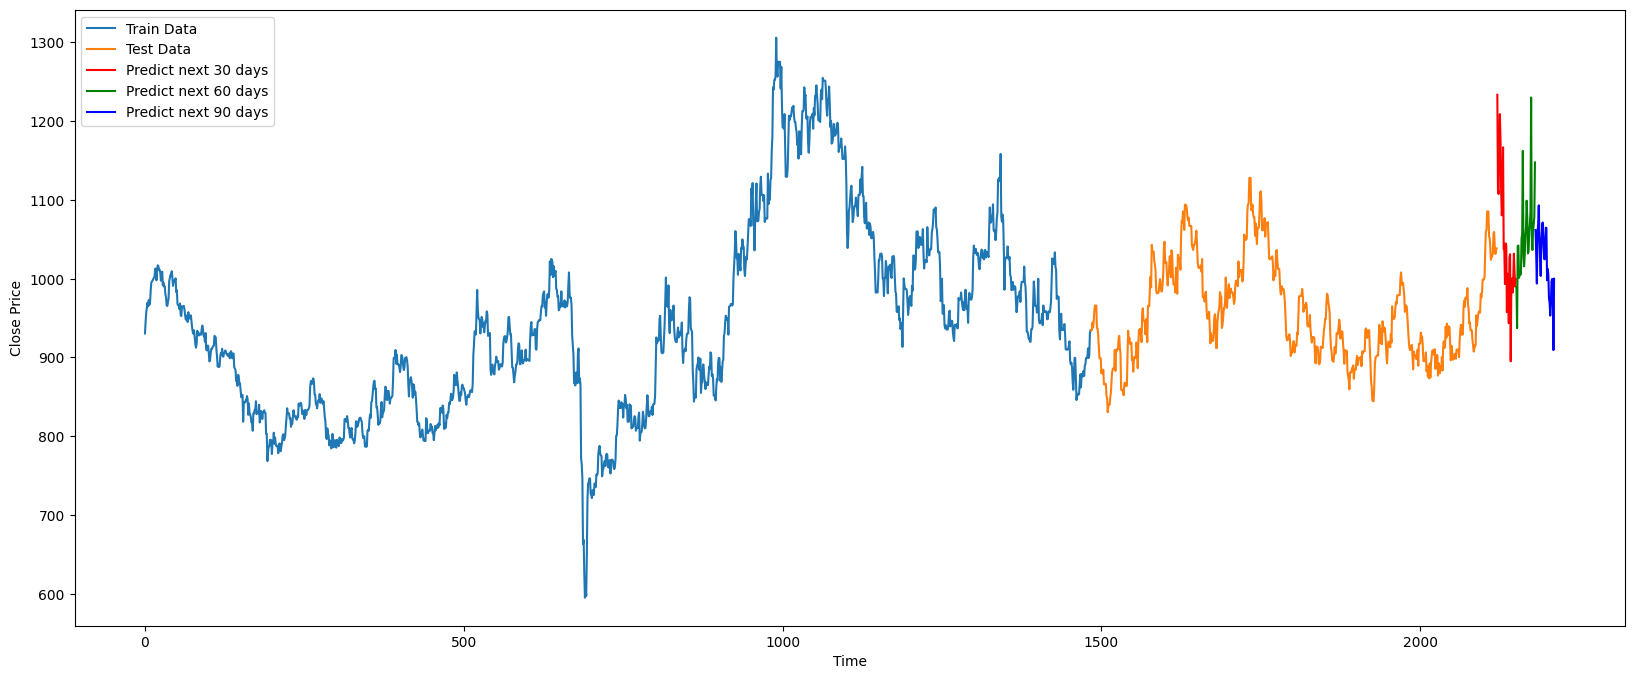

In [14]:
# Plot train, test value and next 30, 60, 90 next day
np.append(test, pred_values[len(pred_values) - 1])

train_index = np.arange(len(train))
test_index = np.arange(len(train), len(train) + len(test))
pred_index = np.arange(len(train) + len(test), len(train) + len(test) + len(pred_values))

plt.plot(train_index, train, label='Train Data')
plt.plot(test_index, test, label='Test Data')
split = len(pred_values) // 3
colors = ['r', 'g', 'b']
labels = ['Predict next 30 days', 'Predict next 60 days', 'Predict next 90 days']

for i in range(3):
    start = i * split
    end = (i + 1) * split if i < 2 else len(pred_values)
    plt.plot(pred_index[start:end], pred_values[start:end], color=colors[i], label=labels[i])

plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()